## Import Library

In [1]:
test_size = 0.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

Mounted at /content/drive


## Load Dataset

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Oversampling Techniques/Data/AIDS_ClinicalTrial_GroupStudy175.csv')

In [6]:
dataset

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,race,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,label
0,948,2,48,89.8128,0,0,0,100,0,0,1,0,0,0,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,1,895,0,0,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,1,707,0,1,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,1,1399,0,1,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,1,1352,0,1,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,1,842,0,1,1,3,0,1,1,152,109,561,720,0
2135,395,0,17,102.9672,1,0,0,100,0,1,1,417,1,1,1,3,0,0,1,373,218,1759,1030,0
2136,1104,2,53,69.8544,1,1,0,90,0,1,1,753,1,1,1,3,0,1,0,419,364,1391,1041,0
2137,465,0,14,60.0000,1,0,0,100,0,0,1,0,0,1,0,1,0,0,0,166,169,999,1838,1


## Exploratory Data Analysis

In [7]:
# check data duplicates

duplicates = dataset[dataset.duplicated()]
duplicates

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,race,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,label


In [9]:
# check missing values

print("Missing Values : ")
print(dataset.isnull().sum())

Missing Values : 
time       0
trt        0
age        0
wtkg       0
hemo       0
homo       0
drugs      0
karnof     0
oprior     0
z30        0
zprior     0
preanti    0
race       0
gender     0
str2       0
strat      0
symptom    0
treat      0
offtrt     0
cd40       0
cd420      0
cd80       0
cd820      0
label      0
dtype: int64


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   trt      2139 non-null   int64  
 2   age      2139 non-null   int64  
 3   wtkg     2139 non-null   float64
 4   hemo     2139 non-null   int64  
 5   homo     2139 non-null   int64  
 6   drugs    2139 non-null   int64  
 7   karnof   2139 non-null   int64  
 8   oprior   2139 non-null   int64  
 9   z30      2139 non-null   int64  
 10  zprior   2139 non-null   int64  
 11  preanti  2139 non-null   int64  
 12  race     2139 non-null   int64  
 13  gender   2139 non-null   int64  
 14  str2     2139 non-null   int64  
 15  strat    2139 non-null   int64  
 16  symptom  2139 non-null   int64  
 17  treat    2139 non-null   int64  
 18  offtrt   2139 non-null   int64  
 19  cd40     2139 non-null   int64  
 20  cd420    2139 non-null   int64  
 21  cd80     2139 

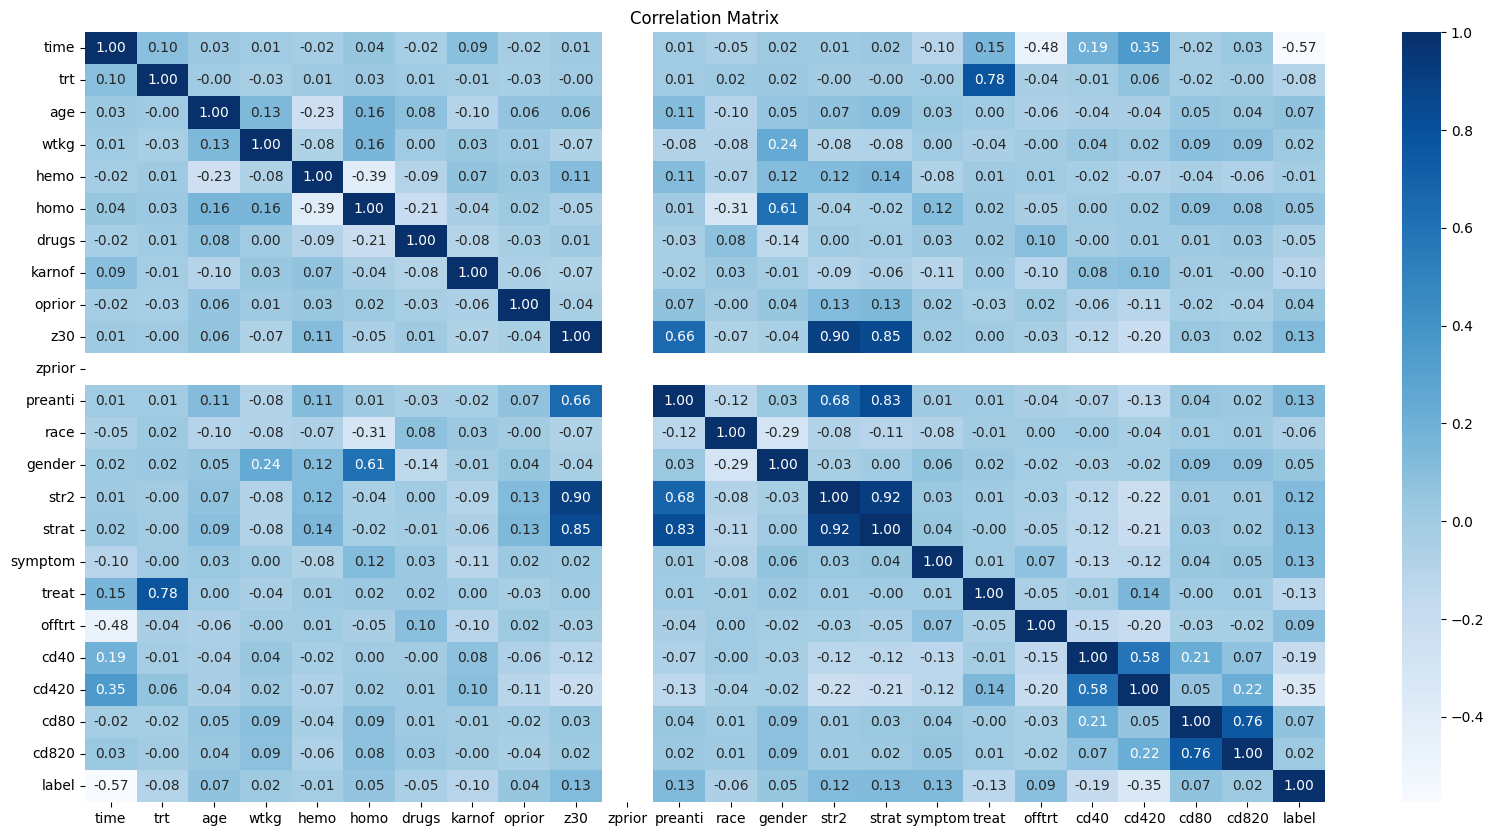

In [12]:
# display the correlation matrix

plt.figure(figsize=(20, 10))
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [13]:
dataset.isnull().values.any()

False

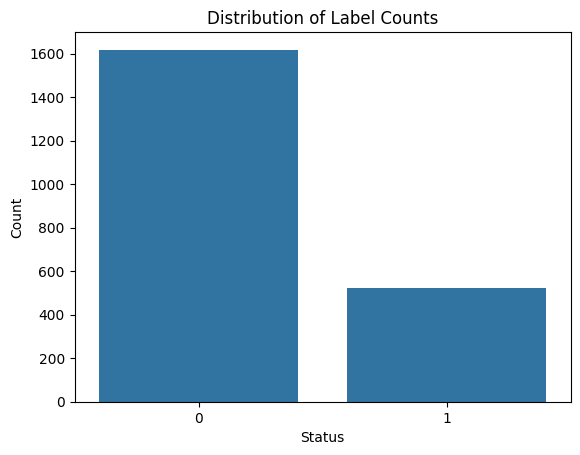

Count of each unique value in 'counts':
label
0    1618
1     521
Name: count, dtype: int64


In [14]:
# display the distribution of target variable ('label')

sns.countplot(x='label', data=dataset)
plt.title('Distribution of Label Counts')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

counts = dataset['label'].value_counts()

print("Count of each unique value in 'counts':")
print(counts)

In [15]:
x = dataset.drop(['label'], axis=1)
y = dataset.label

In [16]:
# standardize the data

sc = StandardScaler()
x = sc.fit_transform(x)

## Random Oversampling

<ipython-input-18-f1436a850446>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=axes[0], palette=palette)
<ipython-input-18-f1436a850446>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette=palette)


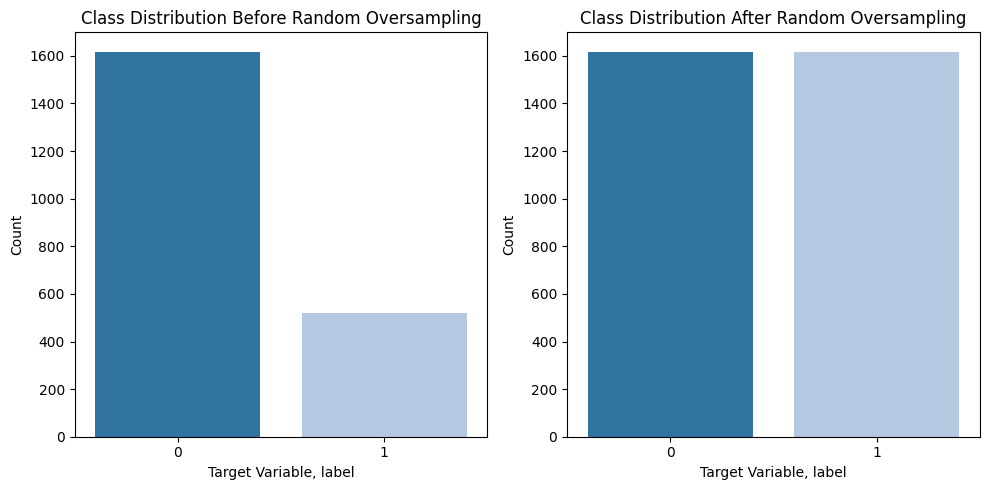

In [18]:
# Apply Random Oversampling
random_oversampler = RandomOverSampler(random_state=42)
x_resampled, y_resampled = random_oversampler.fit_resample(x, y)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
palette = ['#1f77b4', '#aec7e8']

# Before Random Oversampling
sns.countplot(x=y, ax=axes[0], palette=palette)
axes[0].set_title('Class Distribution Before Random Oversampling')
axes[0].set_xlabel('Target Variable, label')
axes[0].set_ylabel('Count')

# After Random Oversampling
sns.countplot(x=y_resampled, ax=axes[1], palette=palette)
axes[1].set_title('Class Distribution After Random Oversampling')
axes[1].set_xlabel('Target Variable, label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Modelling & Evaluation

In [19]:
# Splitting train & test set
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled,test_size=test_size,random_state=42)
X_train.shape, X_test.shape

((2588, 23), (648, 23))

In [20]:
# building the models
def evaluate_model(true, predicted, is_regression=False):
    if is_regression:
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        rmse = np.sqrt(mean_squared_error(true, predicted))
        r2_square = r2_score(true, predicted)
        return mae, rmse, r2_square
    else:
        accuracy = accuracy_score(true, predicted)
        precision = precision_score(true, predicted)
        recall = recall_score(true, predicted)
        f1 = f1_score(true, predicted)
        roc_auc = roc_auc_score(true, predicted)
        return accuracy, precision, recall, f1, roc_auc

In [22]:
# apply XGBoost Classifier
models = {"XGBoost Classifier": XGBClassifier()}

model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for model_name, model in models.items():
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    accuracy, precision, recall, f1, roc_auc=evaluate_model(y_test, y_test_pred, is_regression=False)


    print(model_name)
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(accuracy))
    print("- Precision: {:.4f}".format(precision))
    print("- Recall: {:.4f}".format(recall))
    print("- F1 Score: {:.4f}".format(f1))
    print("- ROC AUC Score: {:.4f}".format(roc_auc))
    print('='*35)
    print('\n')

    model_list.append(model_name)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

XGBoost Classifier
Model performance for Test set
- Accuracy: 0.9444
- Precision: 0.9072
- Recall: 0.9874
- F1 Score: 0.9456
- ROC AUC Score: 0.9454




### Evaluation

In [23]:
# Evaluation Metrics
from sklearn.metrics import classification_report,confusion_matrix
model=XGBClassifier()
clf=model.fit(X_train, y_train)
pred=clf.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       331
           1       0.91      0.99      0.95       317

    accuracy                           0.94       648
   macro avg       0.95      0.95      0.94       648
weighted avg       0.95      0.94      0.94       648

[[299  32]
 [  4 313]]


**Kesimpulan**


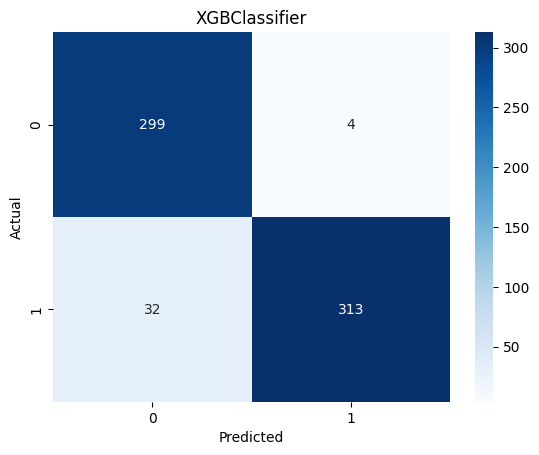

In [24]:
# Confusion Matrix Random Forest
sns.heatmap(confusion_matrix(pred,y_test),annot = True,fmt = "d", cmap='Blues')
plt.title("XGBClassifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()